# Week 4 - Preprocessing.

We'll be getting the data ready to be fed into a model, taking steps such as transforming the data (aggregation), removing columns (Month Grouping and Month abbreviation, etc), and one hot encoding for variables like Land Border Region or Title of Authority that won't give us 30+ more variables. 

In [2]:
from _Setup import *

Installing dependencies from requirements.txt...
All dependencies installed successfully.


In [3]:
sector_train = pd.read_csv(sector_data_csv_path_train)
sector_train.head(5)


,Fiscal Year,Month Grouping,Month (abbv),Component,Land Border Region,Area of Responsibility,AOR (Abbv),Demographic,Citizenship,Title of Authority,Encounter Type,Encounter Count,Year-Date
0,2020,FYTD,OCT,Office of Field Operations,Northern Land Border,Boston Field Office,Boston,FMUA,BRAZIL,Title 8,Inadmissibles,2,2019-10-01
1,2020,FYTD,OCT,Office of Field Operations,Northern Land Border,Boston Field Office,Boston,FMUA,OTHER,Title 8,Inadmissibles,29,2019-10-01
2,2020,FYTD,OCT,Office of Field Operations,Northern Land Border,Boston Field Office,Boston,Single Adults,BRAZIL,Title 8,Inadmissibles,1,2019-10-01
3,2020,FYTD,OCT,Office of Field Operations,Northern Land Border,Boston Field Office,Boston,Single Adults,CANADA,Title 8,Inadmissibles,1031,2019-10-01
4,2020,FYTD,OCT,Office of Field Operations,Northern Land Border,Boston Field Office,Boston,Single Adults,"CHINA, PEOPLES REPUBLIC OF",Title 8,Inadmissibles,9,2019-10-01


In [3]:
sector_test = pd.read_csv(sector_data_csv_path_test)
sector_test.head()

,Fiscal Year,Month Grouping,Month (abbv),Component,Land Border Region,Area of Responsibility,AOR (Abbv),Demographic,Citizenship,Title of Authority,Encounter Type,Encounter Count,Year-Date
0,2024,Remaining,JAN,Office of Field Operations,Northern Land Border,Boston Field Office,Boston,Accompanied Minors,CANADA,Title 8,Inadmissibles,1,2024-01-01
1,2024,Remaining,JAN,Office of Field Operations,Northern Land Border,Boston Field Office,Boston,Accompanied Minors,OTHER,Title 8,Inadmissibles,1,2024-01-01
2,2024,Remaining,JAN,Office of Field Operations,Northern Land Border,Boston Field Office,Boston,FMUA,BRAZIL,Title 8,Inadmissibles,42,2024-01-01
3,2024,Remaining,JAN,Office of Field Operations,Northern Land Border,Boston Field Office,Boston,FMUA,CANADA,Title 8,Inadmissibles,24,2024-01-01
4,2024,Remaining,JAN,Office of Field Operations,Northern Land Border,Boston Field Office,Boston,FMUA,"CHINA, PEOPLES REPUBLIC OF",Title 8,Inadmissibles,38,2024-01-01


In [4]:
# These columns should be captured in Year-Date and we remove abbreviated columns that are unnecessary.
columns_to_remove = ["Fiscal Year", "Month Grouping", "Month (abbv)", "AOR (Abbv)"]
sector_train_dropped = sector_train.drop(columns = columns_to_remove)
sector_test_dropped = sector_test.drop(columns = columns_to_remove)

In [5]:
sector_train_dropped.head(5)

,Component,Land Border Region,Area of Responsibility,Demographic,Citizenship,Title of Authority,Encounter Type,Encounter Count,Year-Date
0,Office of Field Operations,Northern Land Border,Boston Field Office,FMUA,BRAZIL,Title 8,Inadmissibles,2,2019-10-01
1,Office of Field Operations,Northern Land Border,Boston Field Office,FMUA,OTHER,Title 8,Inadmissibles,29,2019-10-01
2,Office of Field Operations,Northern Land Border,Boston Field Office,Single Adults,BRAZIL,Title 8,Inadmissibles,1,2019-10-01
3,Office of Field Operations,Northern Land Border,Boston Field Office,Single Adults,CANADA,Title 8,Inadmissibles,1031,2019-10-01
4,Office of Field Operations,Northern Land Border,Boston Field Office,Single Adults,"CHINA, PEOPLES REPUBLIC OF",Title 8,Inadmissibles,9,2019-10-01


These dataframes are prepped for simple time series models that follow a continuous variable throughout time for a given variable. In this case, because we're working with Sector-level data, we aggregate by Area of Responsibility to see the total encounter count for each sector/field office each month. 

In [6]:
# Aggregating by 'Area of Responsibility' and 'Year-Date'
sector_train_aggregated = sector_train_dropped.groupby(["Area of Responsibility", "Year-Date"], as_index=False).agg({"Encounter Count": "sum"})
sector_train_pivot = sector_train_aggregated.pivot(index = "Area of Responsibility", columns = "Year-Date", values="Encounter Count")
sector_train_pivot = sector_train_pivot.fillna(0)
sector_train_pivot.to_csv(sector_data_csv_path_train_pivoted)
sector_train_pivot.head()

Year-Date,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,...,2023-03-01,2023-04-01,2023-05-01,2023-06-01,2023-07-01,2023-08-01,2023-09-01,2023-10-01,2023-11-01,2023-12-01
Area of Responsibility,,,,,,,,,,,,,,,,,,,,,
Atlanta Field Office,1022.0,762.0,564.0,527.0,521.0,847.0,1037.0,2141.0,1532.0,1428.0,...,1102.0,1206.0,1260.0,1280.0,899.0,1012.0,1150.0,917.0,1172.0,987.0
Baltimore Field Office,443.0,550.0,658.0,698.0,660.0,367.0,85.0,177.0,150.0,116.0,...,1599.0,1614.0,1764.0,1609.0,1304.0,1711.0,1748.0,1591.0,1521.0,1539.0
Big Bend Sector,653.0,526.0,543.0,604.0,562.0,675.0,507.0,628.0,660.0,746.0,...,1200.0,1181.0,1421.0,412.0,404.0,568.0,560.0,479.0,426.0,322.0
Blaine Sector,32.0,24.0,36.0,25.0,27.0,16.0,6.0,13.0,5.0,15.0,...,110.0,174.0,115.0,118.0,158.0,188.0,218.0,229.0,198.0,291.0
Boston Field Office,1395.0,1001.0,1558.0,950.0,1350.0,611.0,292.0,54.0,279.0,208.0,...,4173.0,3115.0,3553.0,4007.0,4482.0,5169.0,5576.0,3446.0,3250.0,4236.0


In [7]:
# Aggregating by 'Area of Responsibility' and 'Year-Date'
sector_test_aggregated = sector_test_dropped.groupby(["Area of Responsibility", "Year-Date"], as_index=False).agg({"Encounter Count": "sum"})
sector_test_pivot = sector_test_aggregated.pivot(index = "Area of Responsibility", columns = "Year-Date", values="Encounter Count")
sector_test_pivot = sector_test_pivot.fillna(0)
sector_test_pivot.to_csv(sector_data_csv_path_test_pivoted)
sector_test_pivot.head()

Year-Date,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01,2024-10-01,2024-11-01,2024-12-01
Area of Responsibility,,,,,,,,,,,,
Atlanta Field Office,1073,954,1054,1047,1073,1009,915,869,951,667,484,470
Baltimore Field Office,1565,1586,1440,1290,1253,1408,1126,1226,1136,1156,1171,950
Big Bend Sector,324,568,436,529,751,215,214,308,349,291,282,503
Blaine Sector,223,235,226,330,266,181,99,66,63,69,58,34
Boston Field Office,4508,3611,4736,4945,4809,4514,3989,3452,3432,2684,2031,2277


Was interested in seeing if standard scaler would be appropriate, usually if we know the data is Normal shaped.
Judging by the plots, it doesn't look like any of them are particularly pointing us towards StandardScaler, think we'll go with MinMax Scaler.

Histograms are pretty hard to interpret with the difference in scale across the AORs..

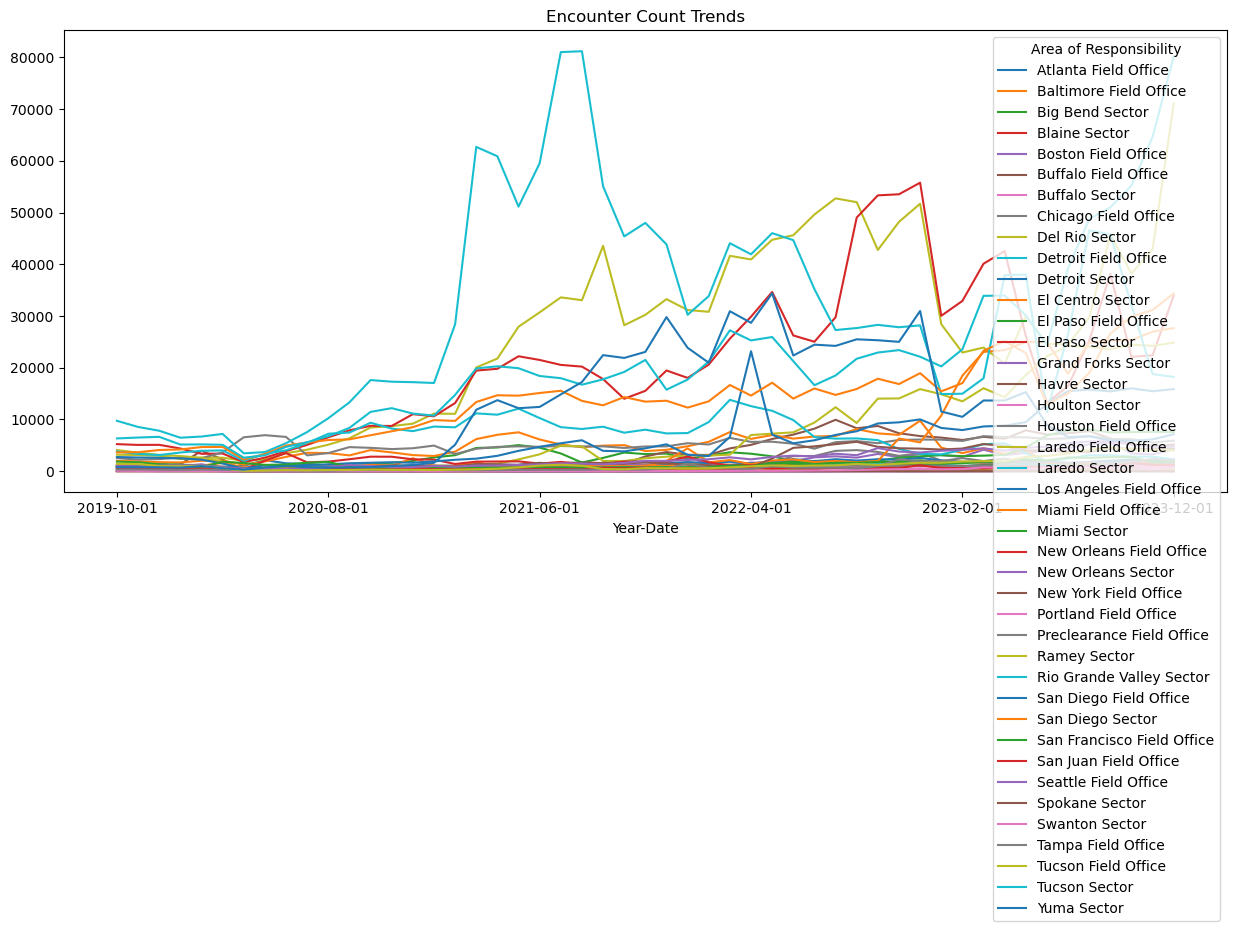

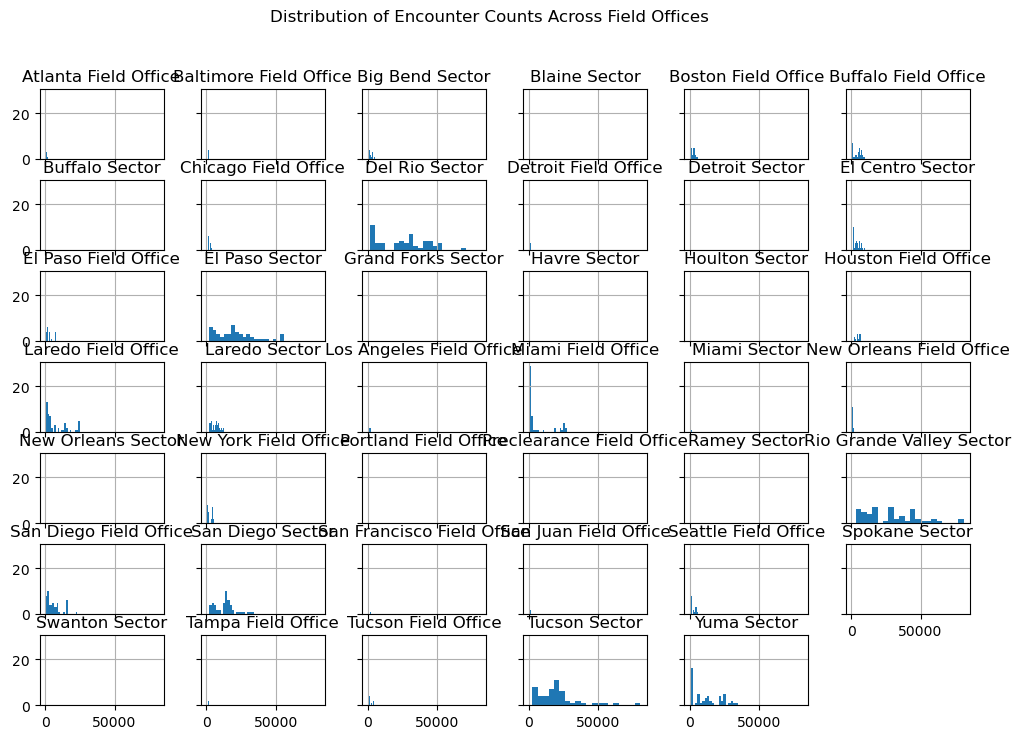

            count         mean           std   min    25%     50%     75%  \
Year-Date                                                                   
2019-10-01   41.0  1491.682927   2012.014220   3.0  146.0   836.0  1851.0   
2019-11-01   41.0  1403.024390   1869.532849  11.0  138.0   804.0  1730.0   
2019-12-01   41.0  1370.390244   1806.336512   1.0  138.0   767.0  1558.0   
2020-01-01   41.0  1274.487805   1555.683083   1.0  129.0   789.0  1343.0   
2020-02-01   41.0  1338.634146   1618.180626   0.0  168.0   770.0  2020.0   
2020-03-01   41.0  1265.097561   1658.386321   0.0  139.0   611.0  1840.0   
2020-04-01   41.0   725.439024   1262.024783   0.0   15.0   185.0   712.0   
2020-05-01   41.0   972.609756   1464.299250   1.0   38.0   245.0  1228.0   
2020-06-01   41.0  1221.609756   1808.027556   0.0   60.0   305.0  1297.0   
2020-07-01   41.0  1309.073171   1982.549803   0.0   95.0   417.0  1428.0   
2020-08-01   41.0  1602.609756   2478.282973   1.0   76.0   579.0  1329.0   

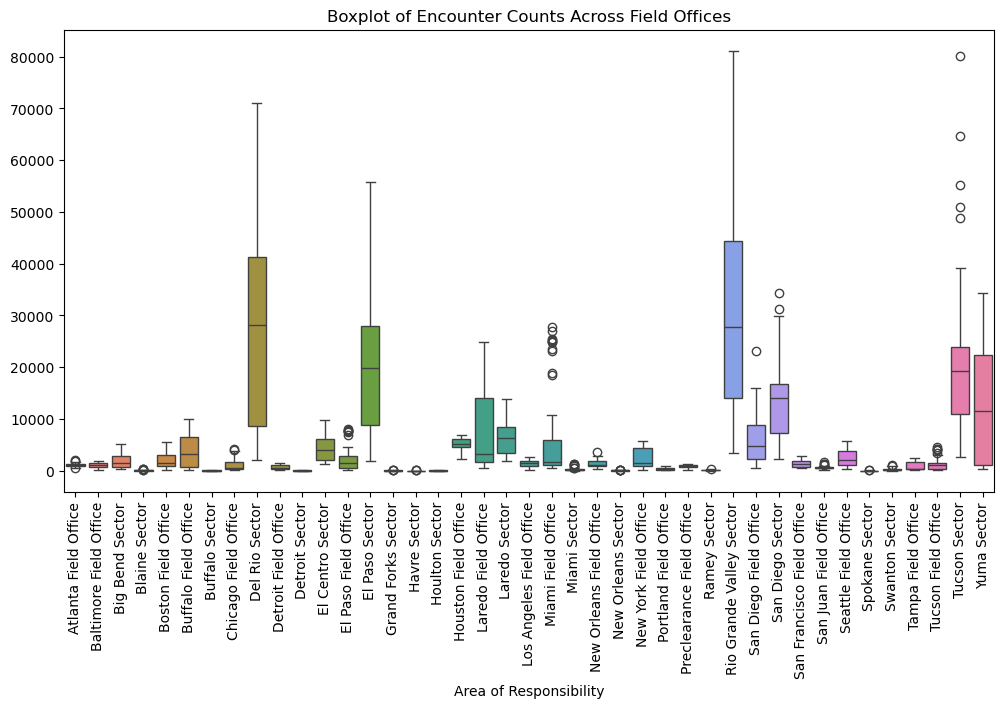

In [8]:
# Transpose for visualization (dates on x-axis, field offices as separate plots)
sector_train_pivot.T.plot(kind='line', figsize=(15, 6), title="Encounter Count Trends")

# Plot histograms for each field office
sector_train_pivot.T.hist(figsize=(12, 8), bins=20, sharex=True, sharey=True)
plt.suptitle("Distribution of Encounter Counts Across Field Offices")
plt.show()

# Compute and print summary statistics
summary_stats = sector_train_pivot.describe().T

print(summary_stats)

# Boxplot for Outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=sector_train_pivot.T)
plt.xticks(rotation=90)
plt.title("Boxplot of Encounter Counts Across Field Offices")
plt.show()

# Min Max Scaler applied to each AOR

We'll apply the actual scaler transformation the following week, but just having the scalers fit will make it much easier after we figure out the global variable situation. 

In [9]:
# Dictionary to store scalers
scalers = {}

# Iterate through rows and fit a separate MinMaxScaler for each row
for idx, row in sector_train_pivot.iterrows():
    scaler = MinMaxScaler()
    
    # Reshape row into a 2D array with a single column to fit the scaler
    row_array = row.to_numpy().reshape(-1, 1)  
    tf = scaler.fit_transform(row_array)  # Fit scaler to the row
    
    # Store the scaler using the row index as the key
    scalers[idx] = scaler

In [10]:
scalers

{'Atlanta Field Office': MinMaxScaler(),
 'Baltimore Field Office': MinMaxScaler(),
 'Big Bend Sector': MinMaxScaler(),
 'Blaine Sector': MinMaxScaler(),
 'Boston Field Office': MinMaxScaler(),
 'Buffalo Field Office': MinMaxScaler(),
 'Buffalo Sector': MinMaxScaler(),
 'Chicago Field Office': MinMaxScaler(),
 'Del Rio Sector': MinMaxScaler(),
 'Detroit Field Office': MinMaxScaler(),
 'Detroit Sector': MinMaxScaler(),
 'El Centro Sector': MinMaxScaler(),
 'El Paso Field Office': MinMaxScaler(),
 'El Paso Sector': MinMaxScaler(),
 'Grand Forks Sector': MinMaxScaler(),
 'Havre Sector': MinMaxScaler(),
 'Houlton Sector': MinMaxScaler(),
 'Houston Field Office': MinMaxScaler(),
 'Laredo Field Office': MinMaxScaler(),
 'Laredo Sector': MinMaxScaler(),
 'Los Angeles Field Office': MinMaxScaler(),
 'Miami Field Office': MinMaxScaler(),
 'Miami Sector': MinMaxScaler(),
 'New Orleans Field Office': MinMaxScaler(),
 'New Orleans Sector': MinMaxScaler(),
 'New York Field Office': MinMaxScaler(),


In [11]:
# Save the list to a .pickle file
with open(scalers_file, "wb") as file:
    pickle.dump(scalers, file)

Scaler stored for each AOR!

## Add Features for potential multivariate LSTM
To add value here, we can also create parallel time series to incorporate other factors such as the percentage of a country included in the encounters, percentage of unaccompanied minors, or other factors that will be useful in USBCP's planning process.

In [12]:
# Aggregating total encounters from Mexico per group
mexico_encounters = sector_train_dropped[sector_train_dropped["Citizenship"] == "MEXICO"].groupby(["Area of Responsibility", "Year-Date"], as_index=False)["Encounter Count"].sum()
mexico_encounters.head()

,Area of Responsibility,Year-Date,Encounter Count
0,Atlanta Field Office,2019-10-01,25
1,Atlanta Field Office,2019-11-01,24
2,Atlanta Field Office,2019-12-01,22
3,Atlanta Field Office,2020-01-01,19
4,Atlanta Field Office,2020-02-01,43


In [13]:
sector_train_aggregated = sector_train_aggregated.merge(mexico_encounters, on=["Area of Responsibility", "Year-Date"], how="left", suffixes=("", " Mexico"))
sector_train_aggregated['Encounter Count Mexico'] = sector_train_aggregated['Encounter Count Mexico'].fillna(0)
sector_train_aggregated.head()

,Area of Responsibility,Year-Date,Encounter Count,Encounter Count Mexico
0,Atlanta Field Office,2019-10-01,1022,25.0
1,Atlanta Field Office,2019-11-01,762,24.0
2,Atlanta Field Office,2019-12-01,564,22.0
3,Atlanta Field Office,2020-01-01,527,19.0
4,Atlanta Field Office,2020-02-01,521,43.0


We can perform a similar operation to see the aggregated number of unaccompanied minors as well

In [14]:
# Aggregating total encounters from Mexico per group
unaccompanied_encounters = sector_train_dropped[sector_train_dropped["Demographic"] == "UC / Single Minors"].groupby(["Area of Responsibility", "Year-Date"], as_index=False)["Encounter Count"].sum()
unaccompanied_encounters.head()

,Area of Responsibility,Year-Date,Encounter Count
0,Atlanta Field Office,2020-01-01,3
1,Atlanta Field Office,2020-07-01,3
2,Atlanta Field Office,2020-09-01,3
3,Atlanta Field Office,2020-10-01,2
4,Atlanta Field Office,2020-11-01,2


Concatenate the number of encounter column to the aggregated dataframe

In [15]:
sector_train_aggregated = sector_train_aggregated.merge(unaccompanied_encounters, on=["Area of Responsibility", "Year-Date"], how="left", suffixes=("", " UM"))
sector_train_aggregated['Encounter Count UM'] = sector_train_aggregated['Encounter Count UM'].fillna(0)
sector_train_aggregated.head()

,Area of Responsibility,Year-Date,Encounter Count,Encounter Count Mexico,Encounter Count UM
0,Atlanta Field Office,2019-10-01,1022,25.0,0.0
1,Atlanta Field Office,2019-11-01,762,24.0,0.0
2,Atlanta Field Office,2019-12-01,564,22.0,0.0
3,Atlanta Field Office,2020-01-01,527,19.0,3.0
4,Atlanta Field Office,2020-02-01,521,43.0,0.0


Simple enough code to change these into percentages - just for demonstration! These other columns can be used to add value in a parallel series LSTM or other more advanced machine learning method. 

# This section is a bit experimental. 

We'd also like to aggregate Encounter Count by date and Area of Responsibility, making sure we don't lose information such as Demographic, Citizenship, Title of Authority, and Encounter Type, etc.

Making sure we know the starting df shape

In [16]:
sector_train_dropped.shape

(57644, 9)

Creating a copy so I don't mess with the original dataframe

In [17]:
sector_train_dropped_copy = sector_train_dropped
sector_train_dropped_copy.shape

(57644, 9)

If I can duplicate a row, then try to aggregate Encounter Count with respect to all the other columns to retain all relevant information, we can see if this aggregation code is working as intended. Then we can check the original dataframe to see if aggregation is even possible or if all rows are unique!

In [18]:
row_to_dup = sector_train_dropped_copy.loc[1]

df_dup = pd.concat([sector_train_dropped_copy] + [row_to_dup.to_frame().T], ignore_index= True)
df_dup.head()

,Component,Land Border Region,Area of Responsibility,Demographic,Citizenship,Title of Authority,Encounter Type,Encounter Count,Year-Date
0,Office of Field Operations,Northern Land Border,Boston Field Office,FMUA,BRAZIL,Title 8,Inadmissibles,2,2019-10-01
1,Office of Field Operations,Northern Land Border,Boston Field Office,FMUA,OTHER,Title 8,Inadmissibles,29,2019-10-01
2,Office of Field Operations,Northern Land Border,Boston Field Office,Single Adults,BRAZIL,Title 8,Inadmissibles,1,2019-10-01
3,Office of Field Operations,Northern Land Border,Boston Field Office,Single Adults,CANADA,Title 8,Inadmissibles,1031,2019-10-01
4,Office of Field Operations,Northern Land Border,Boston Field Office,Single Adults,"CHINA, PEOPLES REPUBLIC OF",Title 8,Inadmissibles,9,2019-10-01


In [19]:
# Using this to ensure all of the correct columns to use in group_by function
sector_train_dropped_copy.columns

Index(['Component', 'Land Border Region', 'Area of Responsibility',
       'Demographic', 'Citizenship', 'Title of Authority', 'Encounter Type',
       'Encounter Count', 'Year-Date'],
      dtype='object')

In [20]:

group_columns = [
    'Component', 'Land Border Region', 'Area of Responsibility',
       'Demographic', 'Citizenship', 'Title of Authority', 'Encounter Type',
        'Year-Date'
]

# Aggregate Encounter Count by summing it where all other columns are the same
aggregated_df = sector_train_dropped_copy.groupby(group_columns, as_index=False).agg({
    "Encounter Count": "sum"  # Sum the encounter counts for duplicate groups
})

# Display result
print(aggregated_df)

                        Component     Land Border Region  \
0      Office of Field Operations   Northern Land Border   
1      Office of Field Operations   Northern Land Border   
2      Office of Field Operations   Northern Land Border   
3      Office of Field Operations   Northern Land Border   
4      Office of Field Operations   Northern Land Border   
...                           ...                    ...   
57639          U.S. Border Patrol  Southwest Land Border   
57640          U.S. Border Patrol  Southwest Land Border   
57641          U.S. Border Patrol  Southwest Land Border   
57642          U.S. Border Patrol  Southwest Land Border   
57643          U.S. Border Patrol  Southwest Land Border   

      Area of Responsibility         Demographic Citizenship  \
0        Boston Field Office  Accompanied Minors      BRAZIL   
1        Boston Field Office  Accompanied Minors      BRAZIL   
2        Boston Field Office  Accompanied Minors      BRAZIL   
3        Boston Field O

The aggregated dataframe looks to have successfully aggregated the duplicated row with the original row, as the row count has decreased by 1, back to 57644. Let's try this aggregation code on the original dataframe now!

In [21]:

# Aggregate Encounter Count by summing it where all other columns are the same
aggregated_df = sector_train_dropped.groupby(group_columns, as_index=False).agg({
    "Encounter Count": "sum"  # Sum the encounter counts for duplicate groups
})

# Display result
print(aggregated_df)

                        Component     Land Border Region  \
0      Office of Field Operations   Northern Land Border   
1      Office of Field Operations   Northern Land Border   
2      Office of Field Operations   Northern Land Border   
3      Office of Field Operations   Northern Land Border   
4      Office of Field Operations   Northern Land Border   
...                           ...                    ...   
57639          U.S. Border Patrol  Southwest Land Border   
57640          U.S. Border Patrol  Southwest Land Border   
57641          U.S. Border Patrol  Southwest Land Border   
57642          U.S. Border Patrol  Southwest Land Border   
57643          U.S. Border Patrol  Southwest Land Border   

      Area of Responsibility         Demographic Citizenship  \
0        Boston Field Office  Accompanied Minors      BRAZIL   
1        Boston Field Office  Accompanied Minors      BRAZIL   
2        Boston Field Office  Accompanied Minors      BRAZIL   
3        Boston Field O

The original dataframe started out with 57644 rows and after "aggregation", it remains the same, which indicates that aggregation of the data is not possible as each row is unique! 

In [22]:
# We can save this dataframe with dropped variables. Commented out to prevent unnecessary overwrites.
# sector_train_dropped.to_csv(sector_train_dropped_csv_path, index = False)